In [14]:
import torch
import torch.nn.functional as torchfunc
import numpy as np
import os
import numbers
import torchvision.transforms.functional as F

from PIL import Image
from google.colab import drive
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
from math import exp

# Dataset class

In [15]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, train=True, ratio=0.8, transform=None): 
        self.img_dir = img_dir
        self.train = train
        self.ratio = ratio
        filelist = list([(self.img_dir+f) for f in sorted(os.listdir(self.img_dir))])
        ell = len(filelist)
        if train:
            self.file_list = filelist[:int(ell * self.ratio)]
        else: 
            self.file_list = filelist[int(ell * self.ratio):]
        self.data_length = len(self.file_list)
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, item):
        data = Image.open(self.file_list[item]).convert("RGB")
        if self.transform is not None:
            data = self.transform(data)
        return data
    
    def get_file_list(self):
        return self.file_list
    
    def get_data_length(self):
        return self.data_length


# Operator classes

In [16]:
# Define Operator classes
class LinearOperator(torch.nn.Module):
    def __init__(self):
        super(LinearOperator, self).__init__()

    def forward(self, x):
        pass

    def adjoint(self, x):
        pass

    def gramian(self, x):
        return self.adjoint(self.forward(x))

class SelfAdjointLinearOperator(LinearOperator):
    def adjoint(self, x):
        return self.forward(x)

class Identity(SelfAdjointLinearOperator):
    def forward(self, x):
        return x

class OperatorPlusNoise(torch.nn.Module):
    def __init__(self, operator, noise_sigma):
        super(OperatorPlusNoise, self).__init__()
        self.internal_operator = operator
        self.noise_sigma = noise_sigma

    def forward(self, x):
        A_x = self.internal_operator(x)
        return A_x + self.noise_sigma * torch.randn_like(A_x)

# Gaussian Blurring

In [17]:
# blurring
class GaussianBlur(LinearOperator):
    def __init__(self, sigma, kernel_size=5, n_channels=3, n_spatial_dimensions = 2):
        super(GaussianBlur, self).__init__()
        self.groups = n_channels
        if isinstance(kernel_size, numbers.Number):
            self.padding = int(np.floor(kernel_size/2))
            kernel_size = [kernel_size] * n_spatial_dimensions
        else:
            print('KERNEL SIZE MUST BE A SINGLE INTEGER - RECTANGULAR KERNELS NOT SUPPORTED AT THIS TIME')
            exit()
        self.gaussian_kernel = torch.nn.Parameter(self.create_gaussian_kernel(sigma, kernel_size, n_channels),
                                                  requires_grad=False)

    def create_gaussian_kernel(self, sigma, kernel_size, n_channels):
        kernel = 1
        meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])
        for size, mgrid in zip(kernel_size, meshgrids):
            mean = (size - 1) / 2
            kernel *= torch.exp(-((mgrid - mean) / sigma) ** 2 / 2)

        # Make sure norm of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(n_channels, *[1] * (kernel.dim() - 1))
        return kernel

    def forward(self, x):
        return torchfunc.conv2d(x, weight=self.gaussian_kernel, groups=self.groups, padding=self.padding)

    def adjoint(self, x):
        return torchfunc.conv2d(x, weight=self.gaussian_kernel, groups=self.groups, padding=self.padding)


# Main Code

In [18]:
# Load the data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
drive.mount('/content/drive')
data_location = '/content/drive/MyDrive/JFB-sharedfiles/Code/data/'
# data_location = './data/'

transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
bsz = 16 # batch size
kernel_size = 5
kernel_sigma = 5.0
noise_sigma = 1e-2

train_dataset = CelebADataset(data_location, transform=transform)
test_dataset = CelebADataset(data_location, train=False, transform=transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bsz, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bsz, shuffle=False, drop_last=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
data_batch = iter(train_dataloader).next()
data_batch.shape

torch.Size([16, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


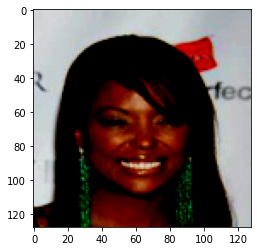

In [20]:
plt.imshow(data_batch[0,:,:,:].permute(1,2,0))

In [21]:
A = GaussianBlur(sigma=kernel_sigma, kernel_size=kernel_size).to(device=device)
measurement_process = OperatorPlusNoise(A, noise_sigma=noise_sigma)
batch_d = measurement_process.forward(data_batch.to(device=device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


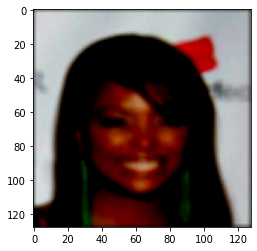

In [22]:
plt.imshow(batch_d[0,:,:,:].permute(1,2,0))

# Gradient Descent
Notations: 
- $x^*$: original image in $\mathbb{R}^n$
- $\mathcal{A}$: forward operator that blurs the image
- $\varepsilon$: noise in $\mathbb{R}^n$
- $d := \mathcal{A} x^\ast + \varepsilon$: measurement of the image in $\mathbb{R}^n$ 

Here, we want to solve the optimization problem 
$$ \min_{x \in \mathbb{R}^n} \frac{1}{2}||\mathcal{A} x - d||_2^2 $$
using the gradient descent scheme. 

Let $f(x) = \frac{1}{2} ||\mathcal{A} x - d||_2^2$. So $\nabla_x f = \mathcal{A}^T (\mathcal{A}x - d)$. 

Set an initial guess for $x$, $x_0 := \mathcal{A}^T d$, with the following updating rule: 
$$ \Delta x = x_{t+1} - x_{t} = - \eta \nabla_x |_{x_t} $$

Stop when $t = T$ for some large $T$ I chose. And use $x_T$ as the output. 

In [23]:
# !pip install pytorch-ignite

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'gradient descent')

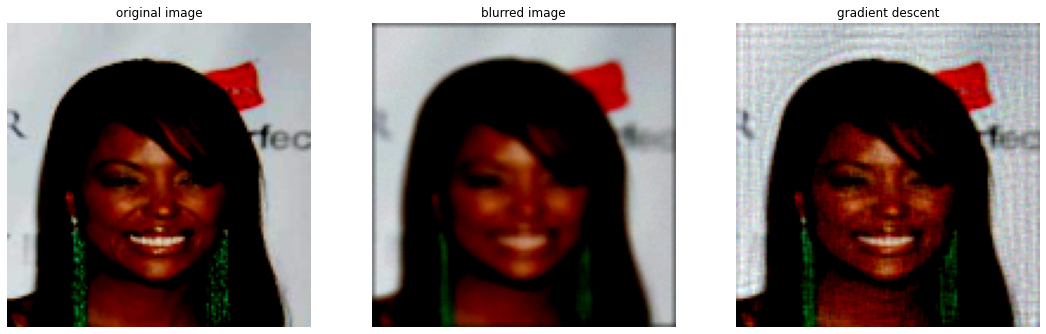

In [24]:
## Use gradient descent
class gd(torch.nn.Module):
    def __init__(self, lr):
        super(gd, self).__init__()

        # Hyperparameter Initialization
        self.lr = lr
    
    def forward(self, d, A, num_iter):
        x = A.adjoint(d) # initial point
        for i in range(num_iter):
            x -= self.lr * A.adjoint(A.forward(x) - d)
        return x

num_iter = 10000
lr = 1e-2
model = gd(lr)
x = model(torch.squeeze(batch_d[0, :, :, :]), A, num_iter)

# plotting
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
fig.add_subplot(1, 3, 1)
plt.imshow(data_batch[0,:,:,:].permute(1, 2, 0))
plt.axis('off')
plt.title("original image")
fig.add_subplot(1, 3, 2)
plt.imshow(batch_d[0, :, :, :].permute(1, 2, 0))
plt.axis('off')
plt.title("blurred image")
fig.add_subplot(1, 3, 3)
plt.imshow(x.permute(1, 2, 0))
plt.axis('off')
plt.title("gradient descent")

# Evaluating GD
Assume we have images $f$ and $g$, both of size $M \times N$. Each pixel takes value in $[0, 255]$. 

To evaluate performance, two metrics are often used: 

1. Peak-signal-to-noise ratio (PSNR), defined as: 
$$PSNR(f, g) = 10 \log_{10} (255^2 / MSE(f, g)), $$
where $$MSE(f, g) := \frac{1}{MN} \sum_{i=1}^M \sum_{j=1}^N (f_{ij} - g_{ij})^2$$

2. Structural similarity index measure (SSIM), defined as: 
$$ SSIM(f, g) = l(f,g) c(f,g)s(f,g), $$
where
$$ l(f,g) := \frac{2\mu_f \mu_g + C_1}{\mu_f^2 + \mu_g^2 + C_1}, \ c(f,g) := \frac{2\sigma_f \sigma_g + C_2}{\sigma_f^2 + \sigma_g^2 + C_2}, \ s(f,g) := \frac{\sigma_{fg} + C_3}{\sigma_f \sigma_g + C_3} $$
$$ \mu_f := \frac{1}{MN} \sum_{i=1}^M \sum_{j=1}^N f_{ij}, \ \mu_g := \frac{1}{MN} \sum_{i=1}^M \sum_{j=1}^N g_{ij} $$
$$\sigma_f^2 = \frac{1}{MN}\sum_{i=1}^M \sum_{j=1}^N (f_{ij} - \mu_f)^2, \ \sigma_g^2 := \frac{1}{MN} \sum_{i=1}^M \sum_{j=1}^N (g_{ij} - \mu_g)^2, \ \sigma_{fg} := \frac{1}{MN}\sum_{i=1}^M \sum_{j=1}^N (f_{ij} - \mu_f)(g_{ij}-\mu_g)$$ 
Positive constants $C_1, C_2, C_3$ are used to avoid null denominator. 

In Gilton's code, they normalized the pixels to [0, 1], and removed the $255^2$ in the numerator when calculating PSNR. This is valid because we have a square in the denominator. But when calculating SSIM, they wrote a different script, which is different from what was used in the pytorch.ignite library, where the constants $C_1, C_2, C_3$ are chosen depending on the image size. 

In [25]:
# Evaluate PSNR using Gilton's metric
mse_loss = torch.nn.MSELoss()
gd_mse = mse_loss(x, data_batch[0, :, :, :]).item()
gd_PSNR = -10 * np.log10(gd_mse)
blur_mse = mse_loss(batch_d[0, :, :, :], data_batch[0, :, :, :]).item()
blur_PSNR = -10 * np.log10(blur_mse)
print(f"PSNR for gradient descent result is {gd_PSNR}")
print(f"PSNR of the blurred image is {blur_PSNR}")

PSNR for gradient descent result is 24.83590126890819
PSNR of the blurred image is 19.788929949809486


In [26]:
# Evaluate SSIM using Gilton's metric
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = torchfunc.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = torchfunc.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = torchfunc.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = torchfunc.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = torchfunc.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)


In [27]:
ssim_calculator = SSIM()
gd_ssim = ssim_calculator.forward(torch.unsqueeze(x, 0), torch.unsqueeze(data_batch[0, :, :, :], 0)).item()
blur_ssim = ssim_calculator.forward(torch.unsqueeze(batch_d[0, :, :, :], 0), torch.unsqueeze(data_batch[0, :, :, :], 0)).item()
print(f"SSIM for gradient descent result is {gd_ssim}")
print(f"SSIM of the blurred image is {blur_ssim}")

SSIM for gradient descent result is 0.7617444396018982
SSIM of the blurred image is 0.7374808192253113


# Inverse of Forward Operator

Here we are going to write discrete 2D convolution as matrix multiplication. 

We first flatten our 2D image $g \in \mathbb{R}^{n \times n}$ to a vector $\vec{g} \in \mathbb{R}^{n^2}$. Since the blurred image also lives in $\mathbb{R}^{n^2}$, we can write the forward operator $\mathcal{A}$ as a matrix that maps from $\mathbb{R}^{n^2} \mapsto \mathbb{R}^{n^2}$, i.e. $\mathcal{A} \in \mathbb{R}^{n^2 \times n^2}$. 

The measurement is $d = \mathcal{A} x$. Using this, the estimator we propose here is $\hat{x} = \mathcal{A}^{-1} d$ when $\mathcal{A}$ is invertible. 

In [28]:
# We do not have noise now! 
(num_channels, H, W) = data_batch[0, :, :, :].size()
A_kernel = torch.squeeze(A.gaussian_kernel[0, :, :])
A_mat = torch.zeros([H*W, H*W])

# Apply to standard basis in R^{H * W}
for i in range(H*W): 
    basis = torch.zeros([num_channels, H*W])
    basis[:, i] = 1
    basis = torch.reshape(basis, [num_channels, H, W])
    basis = A.forward(basis) 
    A_mat[i, :] = torch.reshape(torch.squeeze(basis[0, :, :]), [1, -1])
A_mat = torch.transpose(A_mat, 0, 1)
print(A_mat.shape)

torch.Size([16384, 16384])


In [29]:
# Check whether this A_mat is correct
input_img = torch.reshape(data_batch[0, :, :, :], [num_channels, -1])
img_A = A.forward(data_batch[0, :, :, :])
img_A_mat = torch.matmul(input_img, A_mat).reshape([num_channels, H, W])
norm_difference = torch.norm(img_A - img_A_mat)
print(norm_difference)

tensor(1.1309e-05)


In [30]:
blurred_images = A.forward(data_batch)
blurred_img = torch.reshape(blurred_images[0, :, :, :], [num_channels, -1])
# Apply inverse to get x
# The idea is that each channel can be viewed as an image. Since
# the weights of the kernel are the same for each channel, we can
# apply A_mat to each channel and then stack them to get RGB image
xhat = torch.zeros([num_channels, H*W])
for j in range(num_channels):
    hat = torch.linalg.solve(A_mat, blurred_img[j, :].reshape([-1, 1]))
    xhat[j, :] = torch.reshape(hat, [1, -1])
xhat = xhat.reshape([num_channels, H, W])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'apply A inverse')

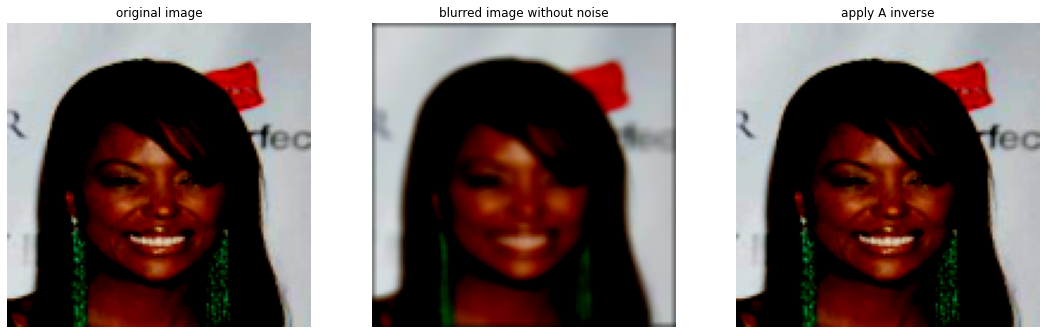

In [31]:
# plotting blurred images WITHOUT noise
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
fig.add_subplot(1, 3, 1)
plt.imshow(data_batch[0,:,:,:].permute(1, 2, 0))
plt.axis('off')
plt.title("original image")
fig.add_subplot(1, 3, 2)
plt.imshow(blurred_images[0, :, :, :].permute(1, 2, 0))
plt.axis('off')
plt.title("blurred image without noise")
fig.add_subplot(1, 3, 3)
plt.imshow(xhat.permute(1, 2, 0))
plt.axis('off')
plt.title("apply A inverse")

In [32]:
print(torch.norm(data_batch[0,:,:,:] - xhat)) # distance from original to recovered

tensor(0.0194)


In [ ]:
# A_eigvals = torch.linalg.eigvals(A_mat) # estimated runtime: ~45 minutes 

In [ ]:
# sorted = -np.sort(-np.real(A_eigvals.numpy()))
# print(sorted[:10])

In [33]:
# We have noise now by using measurement_process
noisy_blurred_images = measurement_process.forward(data_batch)
noisy_img = torch.reshape(noisy_blurred_images[0, :, :, :], [num_channels, -1])
# Apply inverse to get x
xhat = torch.zeros([num_channels, H*W])
for j in range(num_channels):
    hat = torch.linalg.solve(A_mat, noisy_img[j, :].reshape([-1, 1]))
    xhat[j, :] = torch.reshape(hat, [1, -1])
xhat = xhat.reshape([num_channels, H, W])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'apply A inverse')

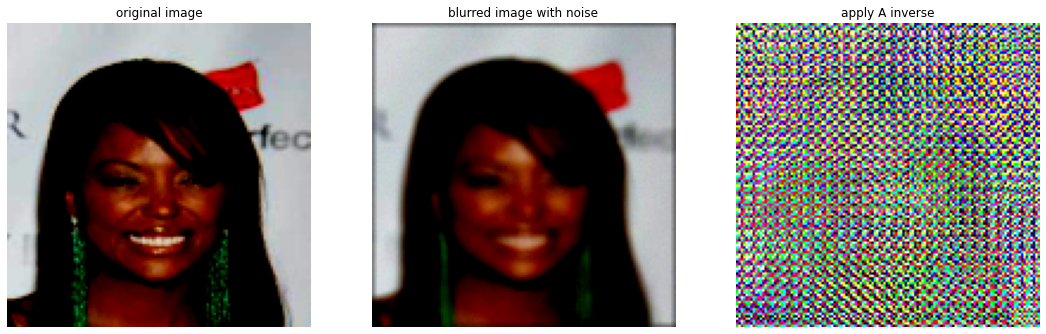

In [34]:
# plotting the noisy case
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
fig.add_subplot(1, 3, 1)
plt.imshow(data_batch[0,:,:,:].permute(1, 2, 0))
plt.axis('off')
plt.title("original image")
fig.add_subplot(1, 3, 2)
plt.imshow(noisy_blurred_images[0, :, :, :].permute(1, 2, 0))
plt.axis('off')
plt.title("blurred image with noise")
fig.add_subplot(1, 3, 3)
plt.imshow(xhat.permute(1, 2, 0))
plt.axis('off')
plt.title("apply A inverse")

In [35]:
print(torch.norm(data_batch[0,:,:,:] - xhat)) # distance from original to recovered

tensor(2326.2166)


# ADMM


In [ ]:
# Use ADMM
